# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [560]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/profile.json', orient='records', lines=True)
transcript = pd.read_json('C:/Users/cmezu/OneDrive/Data Science/Project 4/transcript.json', orient='records', lines=True)

Analysising the data 

I will be analysing the files to understand the data. This will help me understand what needs to be cleaned and how I can use it to analyse the data.

Analysising Portfolio Data

In [561]:
#print portfolio table 
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [562]:
#print portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [563]:
#print null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [564]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [565]:
print(portfolio['offer_type'].value_counts())  # Count offer types

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64


In [566]:
print(portfolio[['duration', 'reward']].describe())  # Summary of duration and reward

        duration     reward
count  10.000000  10.000000
mean    6.500000   4.200000
std     2.321398   3.583915
min     3.000000   0.000000
25%     5.000000   2.000000
50%     7.000000   4.000000
75%     7.000000   5.000000
max    10.000000  10.000000


<Axes: title={'center': 'Offer Types Distribution'}, xlabel='offer_type'>

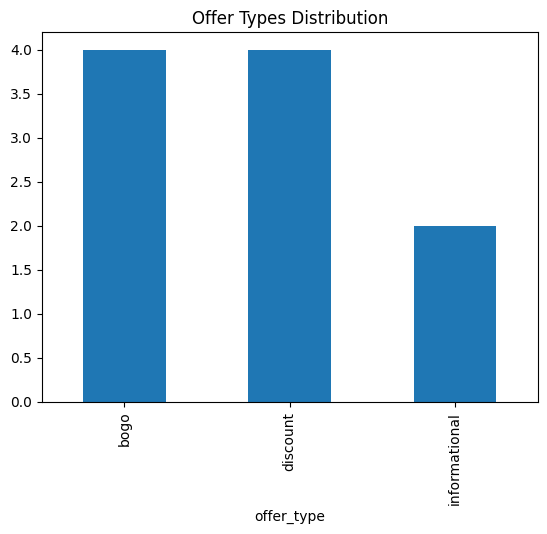

In [567]:
# Visualize offer types
portfolio['offer_type'].value_counts().plot(kind='bar', title='Offer Types Distribution')

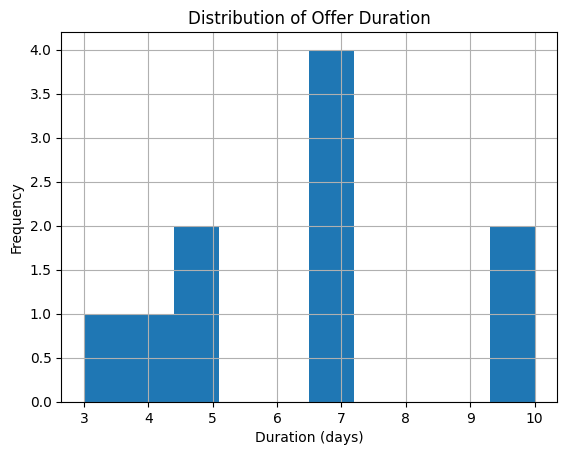

offer_type
bogo             6.0
discount         8.5
informational    3.5
Name: duration, dtype: float64


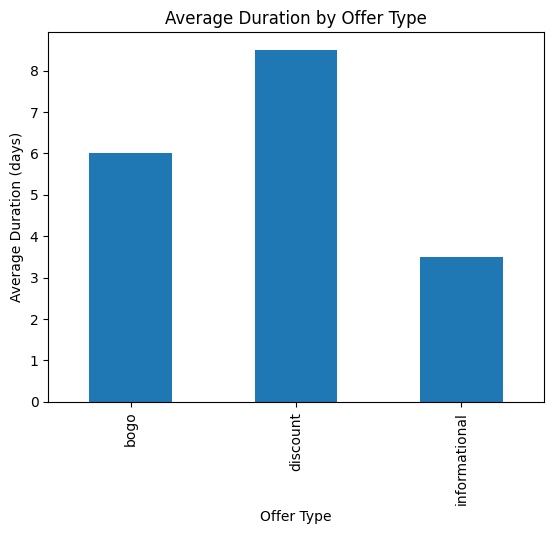

In [568]:
# Distribution of duration
portfolio['duration'].hist(bins=10)
plt.title('Distribution of Offer Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

# Average duration by offer type
duration_by_type = portfolio.groupby('offer_type')['duration'].mean()
print(duration_by_type)

# Visualize duration by offer type
duration_by_type.plot(kind='bar', title='Average Duration by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Average Duration (days)')
plt.show()

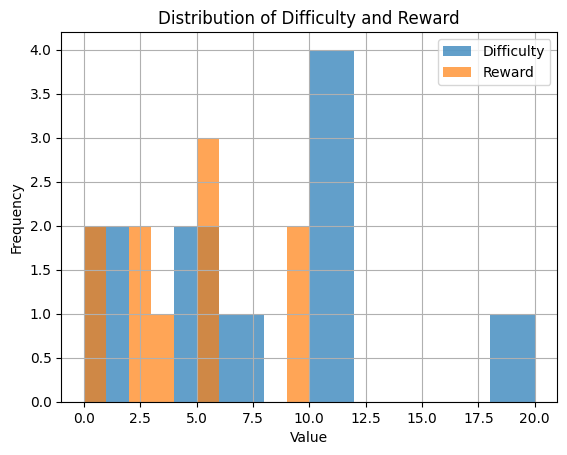

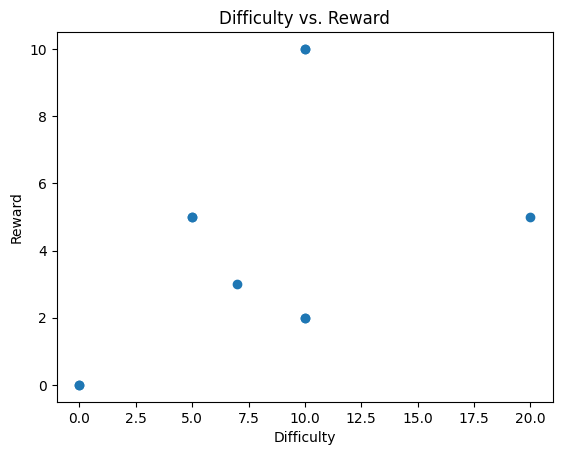

            difficulty    reward
difficulty    1.000000  0.465686
reward        0.465686  1.000000


In [569]:
# Distribution of difficulty and reward
portfolio['difficulty'].hist(bins=10, alpha=0.7, label='Difficulty')
portfolio['reward'].hist(bins=10, alpha=0.7, label='Reward')
plt.title('Distribution of Difficulty and Reward')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of difficulty vs. reward
plt.scatter(portfolio['difficulty'], portfolio['reward'])
plt.title('Difficulty vs. Reward')
plt.xlabel('Difficulty')
plt.ylabel('Reward')
plt.show()

# Correlation between difficulty and reward
correlation = portfolio[['difficulty', 'reward']].corr()
print(correlation)

Counter({'email': 10, 'mobile': 9, 'web': 8, 'social': 6})


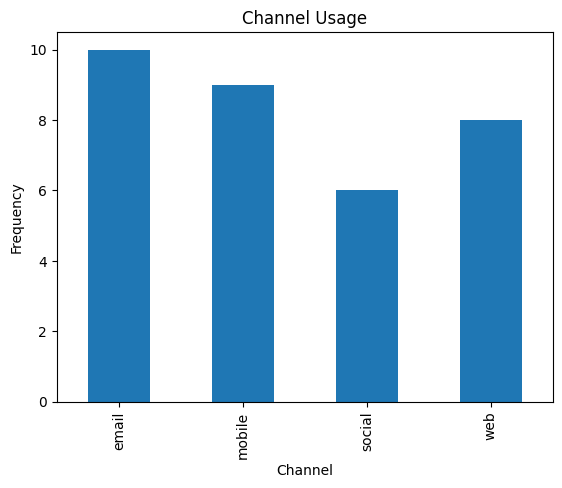

offer_type           
bogo           email     4
               mobile    4
               social    3
               web       3
discount       email     4
               mobile    3
               social    2
               web       4
informational  email     2
               mobile    2
               social    1
               web       1
Name: channels_str, dtype: int64


In [570]:
# Flatten the list of channels
from collections import Counter
channels = Counter([channel for sublist in portfolio['channels'] for channel in sublist])
print(channels)

# Visualize channel usage
pd.Series(channels).plot(kind='bar', title='Channel Usage')
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.show()

# Analyze channels by offer type
portfolio['channels_str'] = portfolio['channels'].apply(lambda x: ', '.join(x))  # Convert list to string for grouping
channels_by_type = portfolio.groupby('offer_type')['channels_str'].apply(lambda x: Counter([channel for sublist in x.str.split(', ') for channel in sublist]))
print(channels_by_type)

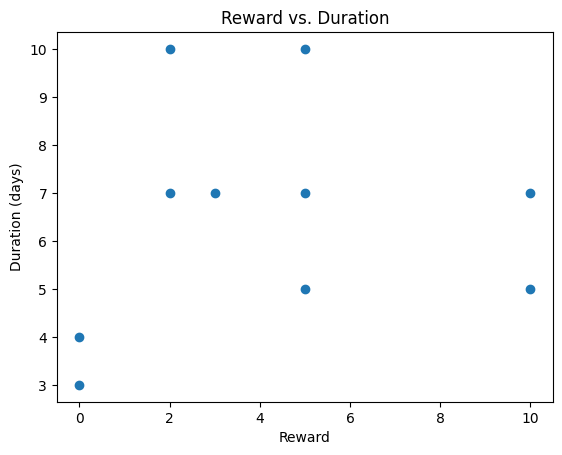

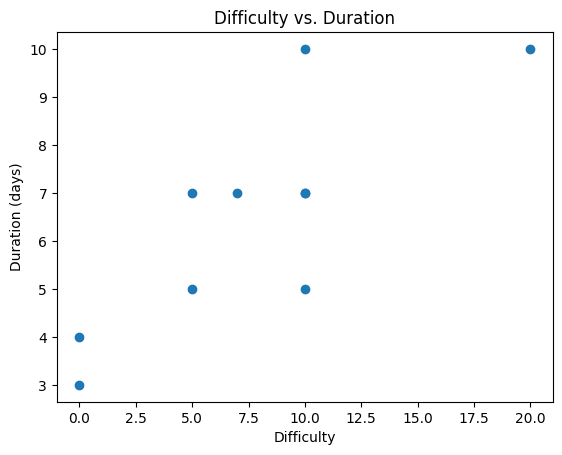

In [571]:
# Analyze reward vs. duration
plt.scatter(portfolio['reward'], portfolio['duration'])
plt.title('Reward vs. Duration')
plt.xlabel('Reward')
plt.ylabel('Duration (days)')
plt.show()

# Analyze difficulty vs. duration
plt.scatter(portfolio['difficulty'], portfolio['duration'])
plt.title('Difficulty vs. Duration')
plt.xlabel('Difficulty')
plt.ylabel('Duration (days)')
plt.show()

In [572]:
portfolio.shape

(10, 7)

Summary of portfolio insights

 Summary of Insights
After analyzing the data, summarize your findings:

Which offer type is most common?
Are higher rewards associated with higher difficulty or longer durations?
Which channels are most frequently used, and do they vary by offer type?

Example Insights:
Offer Types: BOGO and discount offers are more common than informational offers.
Difficulty vs. Reward: Offers with higher rewards tend to have higher difficulty.
Channels: Email and web are the most common channels, while mobile is less frequently used.
Duration: Informational offers tend to have shorter durations compared to BOGO and discount offers.

From my analysis of the porfolio dataset, i can see that:
the data has no null values which means the cleaning process is easier. 
we have a mix of data types and the dataset isn't large


Analysing profile data

In [573]:
#print profile table 
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [574]:
#print profile info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [575]:
#print null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [576]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The max age is 118 which is quite suprising. On average i wouldn't expect to see ages above 100, although this isn't an impossible situation

Understanding age

In [577]:

# Check for ages above 100
print(profile[profile['age'] > 100])  

      gender  age                                id  became_member_on  income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6       None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7       None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
...      ...  ...                               ...               ...     ...
16980   None  118  5c686d09ca4d475a8f750f2ba07e0440          20160901     NaN
16982   None  118  d9ca82f550ac4ee58b6299cf1e5c824a          20160415     NaN
16989   None  118  ca45ee1883624304bac1e4c8a114f045          20180305     NaN
16991   None  118  a9a20fa8b5504360beb4e7c8712f8306          20160116     NaN
16994   None  118  c02b10e8752c4d8e9b73f918558531f7          20151211     NaN

[2180 rows x 5 columns]


In [578]:
# Filter ages above 100
ages_above_100 = profile[profile['age'] > 100]

# Get the value counts of ages above 100
age_counts = ages_above_100['age'].value_counts().reset_index()

# Rename columns for clarity
age_counts.columns = ['Age', 'Count']

# Display the table
print(age_counts)

   Age  Count
0  118   2175
1  101      5


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
gender
M    8484
F    6129
O     212
Name: count, dtype: int64
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


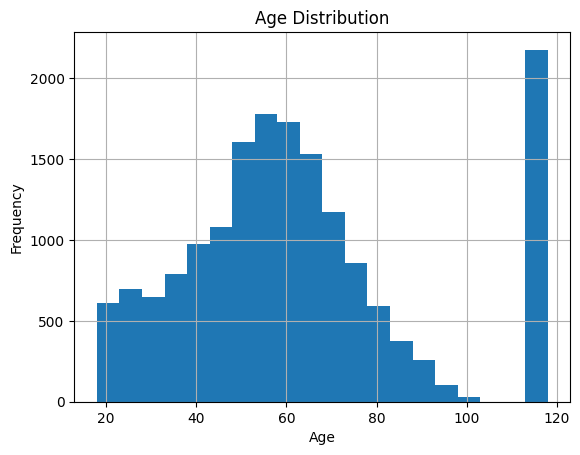

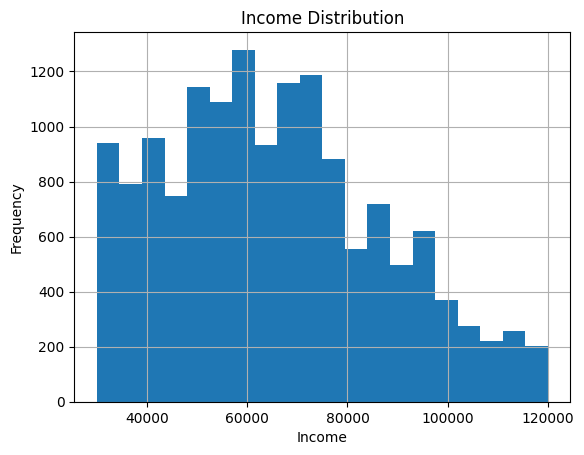

In [579]:
# Analyze profile
print(profile.isnull().sum())  # Check for missing values
print(profile['gender'].value_counts())  # Gender distribution
print(profile['age'].describe())  # Age statistics

# Visualize demographics
profile['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

profile['income'].hist(bins=20)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

There is something looking unusual with age 118, particulatrily when looking at the value count. Age over 100 is less likely, added with the fact that is is incredibly high for 118 and with the fact that the missing vlaues for gender and income match exactly with age count makes it seem there is a problem here

In [580]:
# Filter rows where age is 118
age_118_rows = profile[profile['age'] == 118]

# Check missing values in gender and income for these rows
print(age_118_rows[['gender', 'income']].isnull().sum())

gender    2175
income    2175
dtype: int64


In [581]:
# Create a new dataset without rows where age is 118
profile_cleaned = profile[profile['age'] != 118]

# Verify the rows are removed in the new dataset
print(profile_cleaned['age'].value_counts().get(118, 0))  # Should return 0

# The original 'profile' dataset remains unchanged
print(profile['age'].value_counts().get(118, 0))  # Should still show the count of 118 in the original dataset

0
2175


gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64
gender
M    8484
F    6129
O     212
Name: count, dtype: int64
count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


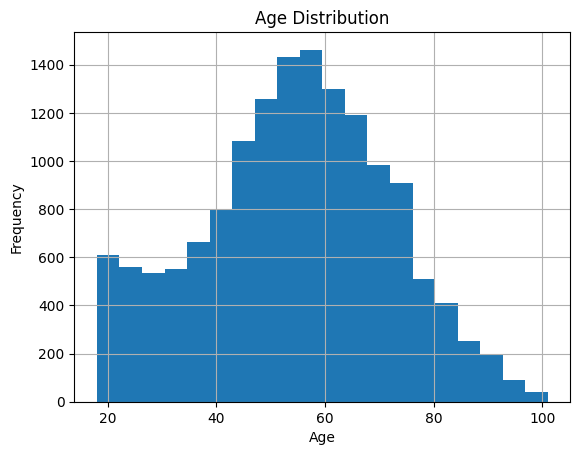

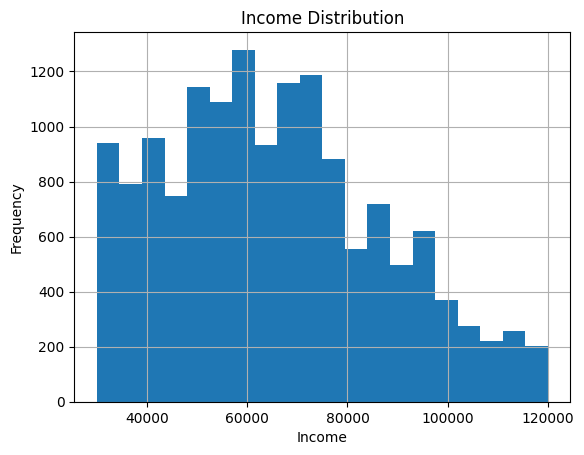

In [582]:
# Analyze profile
print(profile_cleaned.isnull().sum())  # Check for missing values
print(profile_cleaned['gender'].value_counts())  # Gender distribution
print(profile_cleaned['age'].describe())  # Age statistics

# Visualize demographics
profile_cleaned['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

profile_cleaned['income'].hist(bins=20)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

age distribution seems way more realistic without age 118

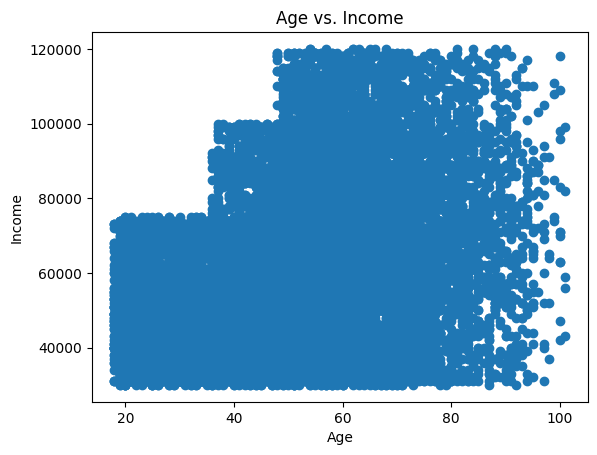

In [583]:
# Age vs. income scatter plot
plt.scatter(profile_cleaned['age'], profile_cleaned['income'])
plt.title('Age vs. Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()



In [584]:
print(profile_cleaned[['age']].info())  # Check data type and null values


<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     14825 non-null  int64
dtypes: int64(1)
memory usage: 231.6 KB
None


Understanding Gender

gender
M    8484
F    6129
O     212
Name: count, dtype: int64


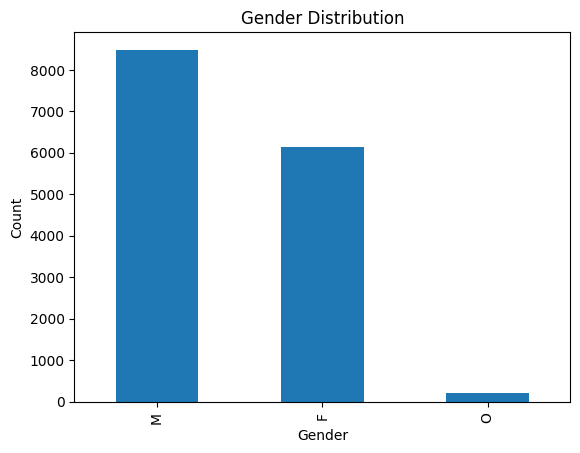

In [585]:
# Gender distribution
print(profile_cleaned['gender'].value_counts())

# Visualize gender distribution
profile_cleaned['gender'].value_counts().plot(kind='bar', title='Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

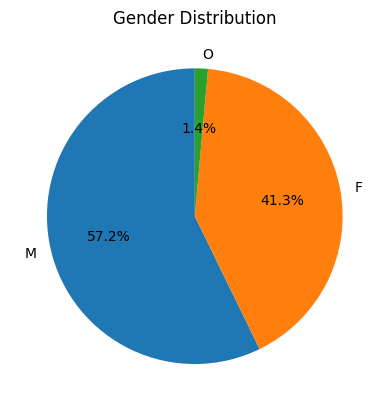

In [586]:
# Gender distribution pie chart
profile_cleaned['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, title='Gender Distribution')
plt.ylabel('')  # Remove y-axis label for better appearance
plt.show()

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64


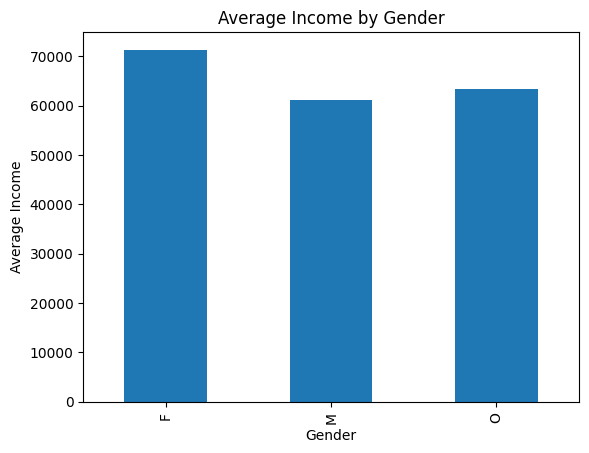

In [587]:
# Income by gender
income_by_gender = profile_cleaned.groupby('gender')['income'].mean()
print(income_by_gender)

# Visualize income by gender
income_by_gender.plot(kind='bar', title='Average Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Income')
plt.show()


In [588]:
# Convert 'became_member_on' to datetime format
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'].astype(str), format='%Y%m%d')

# Extract unique years from the 'became_member_on' column
unique_years = profile_cleaned['became_member_on'].dt.year.unique()

# Display the unique years
print(sorted(unique_years))

[np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018)]


C:\Users\cmezu\AppData\Local\Temp\ipykernel_19864\2996059837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'].astype(str), format='%Y%m%d')


In [589]:
# Extract unique years from the 'became_member_on' column
unique_years = profile_cleaned['became_member_on'].dt.year.unique()

# Display the unique years
print(sorted(unique_years))

[np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018)]


In [590]:
# Ensure 'became_member_on' is a datetime column
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'])

# Group by gender and count membership start years
membership_by_gender = profile_cleaned.groupby('gender')['became_member_on'].apply(lambda x: x.dt.year.value_counts().sort_index())

# Display results
print(membership_by_gender)

gender  F   
F       2013      74
        2014     138
        2015     663
        2016    1509
        2017    2443
        2018    1302
M       2013     197
        2014     520
        2015     905
        2016    1483
        2017    3067
        2018    2312
O       2013       3
        2014       4
        2015      29
        2016      32
        2017      89
        2018      55
Name: became_member_on, dtype: int64


C:\Users\cmezu\AppData\Local\Temp\ipykernel_19864\4157276988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'])


Understanding memberships

C:\Users\cmezu\AppData\Local\Temp\ipykernel_19864\3921540327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')


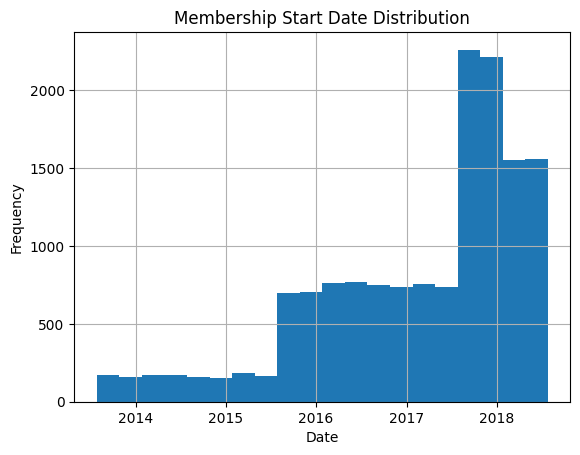

C:\Users\cmezu\AppData\Local\Temp\ipykernel_19864\3921540327.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['membership_year'] = profile_cleaned['became_member_on'].dt.year


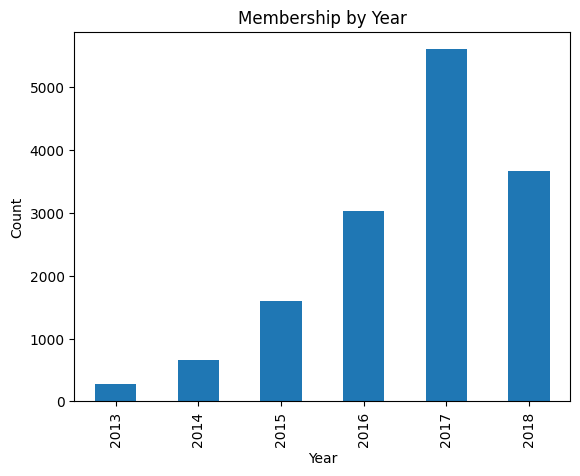

In [591]:
# Convert membership date to datetime
profile_cleaned['became_member_on'] = pd.to_datetime(profile_cleaned['became_member_on'], format='%Y%m%d')

# Plot membership start date distribution
profile_cleaned['became_member_on'].hist(bins=20)
plt.title('Membership Start Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

# Analyze membership by year
profile_cleaned['membership_year'] = profile_cleaned['became_member_on'].dt.year
profile_cleaned['membership_year'].value_counts().sort_index().plot(kind='bar', title='Membership by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [592]:
profile_cleaned.shape

(14825, 6)

C:\Users\cmezu\AppData\Local\Temp\ipykernel_19864\833897052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_cleaned['membership_month'] = profile_cleaned['became_member_on'].dt.month


membership_month
1     1327
2     1042
3     1145
4     1145
5     1152
6     1105
7     1189
8     1395
9     1299
10    1386
11    1268
12    1372
Name: count, dtype: int64


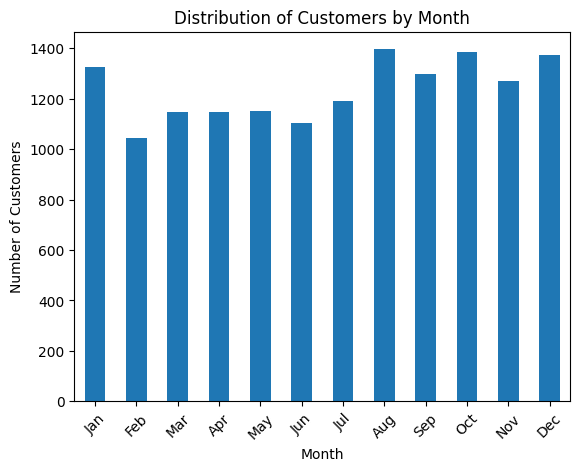

In [593]:
# Extract month from the membership date
profile_cleaned['membership_month'] = profile_cleaned['became_member_on'].dt.month

# Count the number of customers for each month
customers_by_month = profile_cleaned['membership_month'].value_counts().sort_index()

# Display the distribution
print(customers_by_month)

# Visualize the distribution
customers_by_month.plot(kind='bar', title='Distribution of Customers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Its interesting to see it high in august, although maybe because it is hot and summer holidays. Autumn and are winter is when we see peaks. 

8. Insights to Look For
After analyzing the data, summarize your findings:

Age: What is the average age of customers? Are there any outliers?
Gender: Is there a balance between genders? Are there significant differences in income or membership trends by gender?
Income: What is the average income? Are there any correlations between income and other features (e.g., age)?
Membership Trends: When did most customers join the app? Are there spikes in membership during specific years?
Example Insights:
Age: The majority of customers are between 30 and 50 years old, with a few outliers above 100.
Gender: There is a slight imbalance, with more male customers than female customers.
Income: The average income is around $65,000, with a wide range from $30,000 to $120,000.
Membership Trends: Most customers joined the app in recent years, with a spike in membership in 2017.

we are seeing null values which will have to be investageting so that it can be cleaned and for the data to be joined effectively

analysing transcript data

In [594]:
#print 
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [595]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [596]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [597]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [598]:
transcript.shape

(306534, 4)

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


<Axes: title={'center': 'Event Types Distribution'}, xlabel='event'>

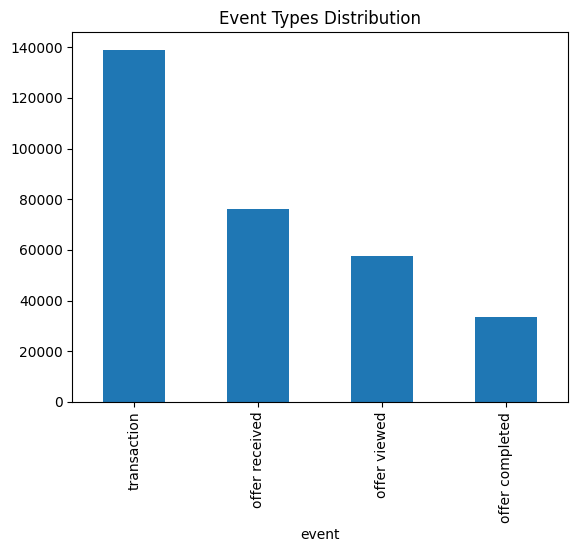

In [599]:
# Analyze transcript
print(transcript['event'].value_counts())  # Count event types

# Convert time to datetime
transcript['time'] = transcript['time'] * 24  # Assuming time is in hours
transcript['time'] = pd.to_datetime(transcript['time'], unit='h', origin='2018-01-01')

# Visualize event distribution
transcript['event'].value_counts().plot(kind='bar', title='Event Types Distribution')

In [600]:
# First, get all customer IDs with age 118
age_118_customers = profile[profile['age'] == 118]['id']

# Count transactions and events for these customers
transactions_age_118 = transcript[transcript['person'].isin(age_118_customers)]

# Display summary statistics
print("=== Analysis of Customers with Age 118 ===")
print(f"\nTotal number of customers with age 118: {len(age_118_customers)}")
print("\nEvent distribution:")
print(transactions_age_118['event'].value_counts())

# For actual transactions only
transactions_only = transactions_age_118[transactions_age_118['event'] == 'transaction']
print(f"\nNumber of transactions: {len(transactions_only)}")

# Calculate total amount spent
if not transactions_only.empty:
	transaction_amounts = transactions_only['value'].apply(lambda x: x.get('amount', 0))
	total_amount_spent = sum(transaction_amounts)
	average_transaction_amount = total_amount_spent / len(transactions_only)
	print(f"\nTotal amount spent: ${total_amount_spent:,.2f}")
	print(f"Average transaction amount: ${average_transaction_amount:,.2f}")
else:
	print("\nNo transactions found for customers with age 118.")

=== Analysis of Customers with Age 118 ===

Total number of customers with age 118: 2175

Event distribution:
event
transaction        14996
offer received      9776
offer viewed        7865
offer completed     1135
Name: count, dtype: int64

Number of transactions: 14996

Total amount spent: $40,509.57
Average transaction amount: $2.70


In [601]:
# Compare transaction patterns between age 118 and other ages
# Get transactions for non-118 age customers
other_age_customers = profile[profile['age'] != 118]['id']
transactions_other_ages = transcript[transcript['person'].isin(other_age_customers)]

# Calculate key metrics for both groups
print("=== Comparative Analysis ===")

# Event distribution comparison
print("\nEvent Distribution:")
print("Age 118:")
print(transactions_age_118['event'].value_counts(normalize=True))
print("\nOther Ages:")
print(transactions_other_ages['event'].value_counts(normalize=True))

# Transaction analysis
transactions_118 = transactions_age_118[transactions_age_118['event'] == 'transaction']
transactions_other = transactions_other_ages[transactions_other_ages['event'] == 'transaction']

# Calculate per customer metrics
transactions_per_customer_118 = len(transactions_118) / len(age_118_customers)
transactions_per_customer_other = len(transactions_other) / len(other_age_customers)

print("\n=== Per Customer Metrics ===")
print(f"Transactions per customer (age 118): {transactions_per_customer_118:.2f}")
print(f"Transactions per customer (other ages): {transactions_per_customer_other:.2f}")

# Percentage of total transactions
total_transactions = len(transactions_118) + len(transactions_other)
print(f"\nPercentage of total transactions:")
print(f"Age 118: {(len(transactions_118)/total_transactions)*100:.2f}%")
print(f"Other ages: {(len(transactions_other)/total_transactions)*100:.2f}%")

# Offer response analysis
offer_completion_118 = transactions_age_118[transactions_age_118['event'] == 'offer completed'].shape[0]
offer_completion_other = transactions_other_ages[transactions_other_ages['event'] == 'offer completed'].shape[0]

print("\n=== Offer Completion Analysis ===")
print(f"Offer completions per customer (age 118): {offer_completion_118/len(age_118_customers):.2f}")
print(f"Offer completions per customer (other ages): {offer_completion_other/len(other_age_customers):.2f}")

=== Comparative Analysis ===

Event Distribution:
Age 118:
event
transaction        0.444036
offer received     0.289471
offer viewed       0.232885
offer completed    0.033608
Name: proportion, dtype: float64

Other Ages:
event
transaction        0.454451
offer received     0.243806
offer viewed       0.182797
offer completed    0.118946
Name: proportion, dtype: float64

=== Per Customer Metrics ===
Transactions per customer (age 118): 6.89
Transactions per customer (other ages): 8.36

Percentage of total transactions:
Age 118: 10.79%
Other ages: 89.21%

=== Offer Completion Analysis ===
Offer completions per customer (age 118): 0.52
Offer completions per customer (other ages): 2.19


Based on the results, here's what we can conclude about age 118 customers versus other ages:

Key Findings:
Event Distribution

Age 118 customers show similar patterns for transactions (44.4% vs 45.4%) and offer received (28.9% vs 24.3%)
However, there's a significant difference in offer completion rates (3.3% vs 11.8%)
Offer viewing rates are slightly higher for age 118 (23.2% vs 18.2%)
Transaction Behavior

Age 118 customers make fewer transactions per customer (6.89 vs 8.36)
They represent 10.79% of total transactions, which is significant
Offer Engagement

Age 118 customers complete far fewer offers per customer (0.52 vs 2.19)
This indicates much lower engagement with offers
Recommendation:
I recommend removing the age 118 customers from the analysis for the following reasons:

Data Quality Issues

Missing gender and income data
Unrealistic age value
Lower engagement metrics suggest these might be placeholder or invalid entries
Behavioral Differences

Significantly lower offer completion rates
Lower transaction frequency per customer
These differences suggest these might not represent real customer behavior
Impact on Analysis

Including these potentially invalid entries could skew our analysis of offer effectiveness
The significant differences in offer completion rates could lead to incorrect conclusions about customer behavior
To proceed with the analysis, you should use the cleaned dataset (profile_cleaned) that excludes age 118 customers to ensure more reliable insights about customer behavior and offer effectiveness.

Cleaning Datasets for merging

In [602]:
def cleaning_portfolio(df):
    """
    Clean the portfolio dataset by renaming columns and converting channels to string format.
    
    Parameters
    ----------
    df : DataFrame
        The portfolio dataset to clean.
    
    Returns
    -------
    df : DataFrame
        The cleaned portfolio dataset.
    """
    # Rename columns for clarity
    df = df.rename(columns={
        'id': 'offer_id',
        'duration': 'offer_duration',
        'difficulty': 'offer_difficulty',
        'reward': 'offer_reward',
        'channels': 'offer_channels',
        'offer_type': 'offer_type'
    })

    # Convert channels to string format
    df['offer_channels'] = df['offer_channels'].apply(lambda x: ','.join(x))

    return df

# Apply the cleaning function to the portfolio dataset
portfolio_cleaned = cleaning_portfolio(portfolio)

# Verify the cleaned dataset
print("Portfolio columns after cleaning:")
print(portfolio_cleaned.columns.tolist())
print(portfolio_cleaned.head())

Portfolio columns after cleaning:
['offer_reward', 'offer_channels', 'offer_difficulty', 'offer_duration', 'offer_type', 'offer_id', 'channels_str']
   offer_reward           offer_channels  offer_difficulty  offer_duration  \
0            10      email,mobile,social                10               7   
1            10  web,email,mobile,social                10               5   
2             0         web,email,mobile                 0               4   
3             5         web,email,mobile                 5               7   
4             5                web,email                20              10   

      offer_type                          offer_id                channels_str  
0           bogo  ae264e3637204a6fb9bb56bc8210ddfd       email, mobile, social  
1           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0  web, email, mobile, social  
2  informational  3f207df678b143eea3cee63160fa8bed          web, email, mobile  
3           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9        

In [603]:
portfolio_cleaned.isnull().sum()

offer_reward        0
offer_channels      0
offer_difficulty    0
offer_duration      0
offer_type          0
offer_id            0
channels_str        0
dtype: int64

In [604]:
portfolio_cleaned.shape

(10, 7)

In [605]:
def cleaning_profile(df):
    """
    Clean the profile dataset by renaming columns, creating age groups, 
    and converting membership_date to datetime format.
    
    Parameters
    ----------
    df : DataFrame
        The profile dataset to clean.
    
    Returns
    -------
    df : DataFrame
        The cleaned profile dataset.
    """
    # Rename columns for clarity
    df = df.rename(columns={
        'id': 'customer_id',
        'became_member_on': 'membership_date'
    })



    # Create and add age groups
    bins = [17, 25, 35, 45, 55, 65, 75, 85, 118]
    labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86+']
    df['age_group'] = pd.cut(df['age'], 
                             bins=bins, 
                             labels=labels, 
                             right=True)

    # Ensure membership_date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['membership_date']):
        df['membership_date'] = pd.to_datetime(df['membership_date'].astype(str), format='%Y%m%d')

    return df

# Apply the cleaning function to the profile dataset
profile_cleaned = cleaning_profile(profile)

# Verify the cleaned dataset
print("\nProfile columns after cleaning:")
print(profile_cleaned.columns.tolist())
print(profile_cleaned.head())


Profile columns after cleaning:
['gender', 'age', 'customer_id', 'membership_date', 'income', 'age_group']
  gender  age                       customer_id membership_date    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783      2017-02-12       NaN   
1      F   55  0610b486422d4921ae7d2bf64640c50b      2017-07-15  112000.0   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5      2018-07-12       NaN   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef      2017-05-09  100000.0   
4   None  118  a03223e636434f42ac4c3df47e8bac43      2017-08-04       NaN   

  age_group  
0       86+  
1     46-55  
2       86+  
3     66-75  
4       86+  


In [606]:
profile_cleaned.isnull().sum()

gender             2175
age                   0
customer_id           0
membership_date       0
income             2175
age_group             0
dtype: int64

In [607]:
profile_cleaned.shape

(17000, 6)

In [608]:
profile.shape

(17000, 5)

In [609]:
profile_cleaned.duplicated().sum()

np.int64(0)

In [610]:
def cleaning_transcript(df):
    """
    Rename columns in the transcript DataFrame to ensure compatibility for merging.

    Parameters
    ----------
    df : DataFrame
        The transcript data frame to clean.

    Returns
    -------
    df : DataFrame
        The cleaned transcript data frame with renamed columns.
    """
    # Rename columns if necessary
    column_renames = {
        'value': 'offer_id',   # If value column is the key holding offer_id
        'person': 'customer_id'  # Ensure consistency with profile_cleaned
    }
    
    # Rename columns safely (only rename if they exist)
    df = df.rename(columns={k: v for k, v in column_renames.items() if k in df.columns})

    return df

# Apply the function
transcript_cleaned = cleaning_transcript(transcript)

In [611]:
transcript_cleaned.isnull().sum()

customer_id    0
event          0
offer_id       0
time           0
dtype: int64

In [612]:
transcript_cleaned.shape

(306534, 4)

Exploratory Data Analysis (EDA)

Merging data frames for EDA

In [613]:
print("Transcript columns:", transcript_cleaned.columns.tolist())
print("Portfolio columns:", portfolio_cleaned.columns.tolist())

Transcript columns: ['customer_id', 'event', 'offer_id', 'time']
Portfolio columns: ['offer_reward', 'offer_channels', 'offer_difficulty', 'offer_duration', 'offer_type', 'offer_id', 'channels_str']


In [614]:
# Modify the merge function to use inner join instead of left join
def merge_cleaned_data(portfolio_cleaned, profile_cleaned, transcript_cleaned):
    """
    Merge the three cleaned Starbucks datasets for analysis.
    """
    # First merge transcript with portfolio data
    merged_df = transcript_cleaned.merge(
        portfolio_cleaned,
        on='offer_id',
        how='left'
    )
    
    # Then merge with profile data using inner join
    merged_df = merged_df.merge(
        profile_cleaned,
        on='customer_id',
        how='inner' 
    )
    


In [615]:
# Verify no null values remain
merged_df.isnull().sum()

customer_id             0
event                   0
time                    0
offer_id           156401
gender                  0
age                     0
membership_date         0
income                  0
age_group               0
amount             148805
dtype: int64

In [616]:
# Check if all the customers in profile dataframe are also in transcript dataframe
len(set(transcript_cleaned['customer_id'].unique()) - set(profile_cleaned['customer_id'].unique()))

0

In [617]:
merged_df.head()

,customer_id,event,time,offer_id,gender,age,membership_date,income,age_group,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,2018-01-01,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,66-75,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,2018-01-01,2906b810c7d4411798c6938adc9daaa5,M,68,2018-04-26,70000.0,66-75,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,2018-01-01,f19421c1d4aa40978ebb69ca19b0e20d,M,65,2018-02-09,53000.0,56-65,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,2018-01-01,3f207df678b143eea3cee63160fa8bed,M,58,2017-11-11,51000.0,56-65,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,2018-01-01,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,61,2017-09-11,57000.0,56-65,NaN


In [618]:
merged_df[merged_df['age'] == 118].head()

,customer_id,event,time,offer_id,gender,age,membership_date,income,age_group,amount


In [619]:
merged_df = merged_df[merged_df['age'] != 118]

In [620]:
merged_df[merged_df['age'] == 118].head()

,customer_id,event,time,offer_id,gender,age,membership_date,income,age_group,amount


In [621]:
# Verify no null values remain
merged_df.isnull().sum()

customer_id             0
event                   0
time                    0
offer_id           156401
gender                  0
age                     0
membership_date         0
income                  0
age_group               0
amount             148805
dtype: int64